In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from scipy.optimize import minimize
from scipy.optimize import curve_fit
# from sklearn import datasets
from scipy.stats import multivariate_normal, norm

In [ ]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape

def objective_1D(z, y, A, Gr, Gi, w=1, lmbda = 0):
    '''
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    
    input

        w - option to put in more variation like Tikhonov?

    '''
    # to do implement size checks for A, z, G
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]

    # evaluations of G = Gr + iGi
    xr = Gr.eval(z) 
    xi = Gi.eval(z) 
    xc = xr + 1j*xi

    Dxr = Gr.jac(z) #k by 2k matrix
    Dxi = Gi.jac(z) #k by 2k matrix

    # evaluations of A
    yp = A.eval(xc)
    Dy = A.jac(xc)

    # compute value and gradient least squares
    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2

    temp   = np.concatenate((np.real(Dy.H@(yp - y)), np.imag(Dy.H@(yp - y))))
    gradr  = Dxr.T@temp
    gradi  = Dxi.T@temp

    # here, shapes should be compatible but gradr, gradi does not output when calling the function

    l = len(gradr)//2
    gradreal = gradr[:l] - gradi[l:] + np.real((lmbda**2)*(w*w)*zc)
    gradimag = gradr[l:] + gradi[:l] + np.imag((lmbda**2)*(w*w)*zc)

    grad = np.concatenate((gradreal, gradimag))
    
    return val, grad

def reconstruct(xtrue, A, Gr, Gi, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = Gr.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective_1D, x0=np.ones(k), args=(yobs, A, Gr, Gi, w, lmbda), method='L-BFGS-B', jac=True) # was originally 2k, but column space of Gr and Gi is length real part + imaginary part
    
    # extract or make complex values
    z = result.x 
    zhat = result.x[:k] + 1j*result.x[k:]

    xr = Gr.eval(z) 
    xi = Gi.eval(z) 
    xhat = xr + 1j*xi
    
    # correct global phase 
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, zhat

In [4]:
def MaskedFourier_1D(M):
    '''
    Masked 1D fourier transform as a linear operator.

    input:
        M - 2D array of size n x m containing m windows of length n
    
    output:
        A - linear operator representing the masked Fourier transforms

    '''
    nx = M.shape[0] # length of window
    mx = M.shape[1] # number of windows

    mv  = lambda x : fft(M*x[:, None], axis=0).flatten()
    rmv = lambda y: np.sum(ifft(y.reshape((nx, mx)), axis=0) * np.conj(M), axis=1).flatten()
    
    A = LinearOperator((nx*mx, nx), matvec=mv, rmatvec = rmv)

    return A

def block_signal(length,starts,heights,widths):
    '''
    input:
        lentgh signal, start (integer index), height, width (integer ndices)
    '''
    nsamples = len(starts)
    signals = np.zeros((nsamples, length))

    for i in range(nsamples):
        start = int(starts[i])
        width = int(widths[i])
        height = heights[i]
        end = min(start + width, length-10)  # Ensure block stays within bounds
        signals[i, start:end] = height
        
    return signals


def sine_signal(n, frequencies):
    '''
    input: grid length, frequencies (nsamples x 3), time
    '''
    nsamples = frequencies.shape[0]
    t = np.linspace(0, 1, n, False)  # 1 second

    signals = np.zeros((nsamples,n))
    for i in range(nsamples):
        signals[i] = np.sin(2*np.pi*frequencies[i,0]*t) + np.sin(2*np.pi*frequencies[i,1]*t) + np.sin(2*np.pi*frequencies[i,2]*t)
        norm = la.norm(signals[i])
        signals[i] = signals[i]/norm
    
    return signals

def cut_off_lowpass(data, highcut):
    '''
    Assumes data shape 
    '''
    data = np.atleast_2d(data)
    n = data.shape[1] # will not go well if X is higher dim
    print("length of signal is ", n)
    k = fftfreq(n,1)
    cut_off = np.where((k < -highcut ) | (k > highcut))[0]
    
    data_fft = fft(data)
    data_fft[:,cut_off] = 0
    new_data = np.real(ifft(data_fft, axis=1)) # also only works for real data
    return (new_data, cut_off) if data.shape[0] > 1 else (new_data[0], cut_off)

# 1D ambiguity function
def Ambiguity(phi,m): #for now, ignore specific frequency component n and compute all
    '''
    input:
        phi - signal of length L
        m - shift of the signal
    output:
        Fourier vector of the signal multiplied by its conjugate shift
    '''
    shift_phi = np.conjugate(np.roll(phi,m))
    return fft(phi*shift_phi)

def ambiguityconst(windows):
    '''
    input:
        windows     window functions (length, number of windows/measurements)
    '''
    mx = len(windows[0,:])
    c = 0
    for i in range(2):
        for j in range(mx): 
            mask_test = Ambiguity(windows[:,j], i)
            temp_max = 1/abs(mask_test).min() #potential hazard of dividing by small numbers
            if temp_max > c:
                c = temp_max
                remember_mask_index = j
    return c, remember_mask_index

# compute stability constant
def stabilityconst(n, x, delta, c):
    '''
    input:
        n       signal gridsize
        x       signal set, specified as (number of samples, length of sample)
        delta   threshold
        c       ambiguity function threshold   
    output:
        constant bound for reconstruction
    '''
    max_norm = np.max(np.linalg.norm(x, axis = 1)) # along rows
    C = c/delta*(1 + np.sqrt(2*n*max_norm)/delta)
    return C

In [5]:
# define experiment
def run_experiment(Xtrue, A, Gr, Gi, sigmas):
    nsigmas = len(sigmas)
    k       = Gr.shape[1]
    print(k)
    Xhat    = np.zeros((n,nsamples,nsigmas),dtype=complex)
    errors  = np.zeros((nsamples,nsigmas))
    zhat    = np.zeros((k,nsamples,nsigmas),dtype=complex)
    
    for i in range(nsamples):
        for j in range(nsigmas):
             errors[i,j], Xhat[:,i,j], zhat[:,i,j] = reconstruct(Xtrue[i,:], A, Gr, Gi, sigma = sigmas[j])
    
    return Xhat, errors, zhat

def plot_experiment(Xhat, errors, Xtrue, sigmas):
    nsigmas = len(sigmas)
    
    fig,ax  = plt.subplots(nsigmas,5,sharey=True)

    for j in range(nsigmas):
        for i in range(5):
            ax[j,i].plot(domain,Xtrue[i,:],'k--')
            ax[j,i].plot(domain,np.real(Xhat[:,i,j]),'r')
            ax[j,i].set_ylim([0,1])
            ax[j,i].set_aspect(1)

    fig.tight_layout()
    plt.show()
    print('sigma    | error (std)')
    for j in range(nsigmas):
        print('%1.2e | %1.2e (%1.2e)'%(sigmas[j],np.mean(errors[:,j]),np.std(errors[:,j])))

In [6]:
# parameters
delta    = 0.5 # threshold
nsamples = 5  # number of samples to generate for validation
n        = 100  # grid size for signal
mx       = 5 # number of measurements masks
bandwidth = .12 # relative bandwidth for generative model \in (0,1]
sigmas   = [1e-3, 1e-2, 1e-1] # noise levels to use for validation

# grid
domain   = np.linspace(0,1,n)

(5, 100)
0.26320458009157854
0.7367954199084223
0.06927665098118418
0.01


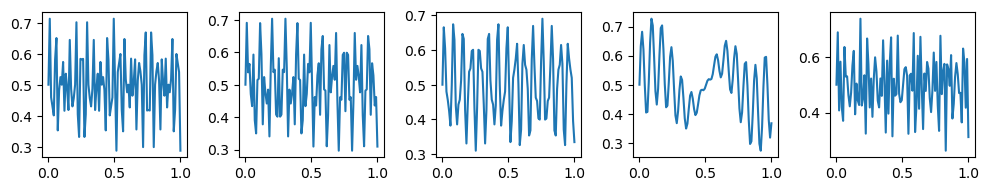

0.26339447788665615
0.7368632782260414
0.0693766509811842
0.01


In [7]:
# create data set 
frequencies = np.random.randint(2,50, size=(nsamples,3))

Xtrue = sine_signal(n,frequencies) + delta
print(Xtrue.shape)
smallest = np.min(Xtrue)
print(smallest)
print(np.max(Xtrue))

print(smallest**2)
print(1/n)

fig,ax = plt.subplots(1,5, figsize=(10, 2.5))

for i in range(5):
    ax[i].plot(domain,Xtrue[i,:])
    #ax[i].set(aspect='equal')
    ax[i].set_box_aspect(1)

fig.tight_layout()
plt.show()

# make complex phase retrieval set
Xcomplex = 0.01*np.ones((nsamples,n)) + 1j*Xtrue

smallest = np.min(np.abs(Xcomplex))
print(smallest)
print(np.max(np.abs(Xcomplex)))

print(smallest**2)
print(1/n)

length of signal is  100
75


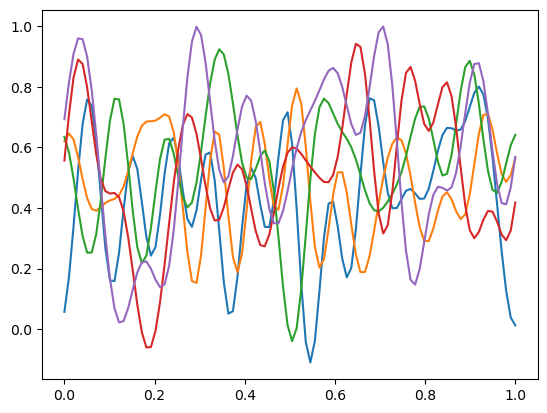

In [8]:
# describes mx window functions of length n
windows = np.zeros((n,mx)) # grid x number of measurements is different from true signal
mu      = np.random.uniform(0,1,mx)
#windows = norm.pdf(domain[:, np.newaxis], mu, .02) # do not use a high variance, leads to small values ambiguity function
windows = np.random.randint(0,2,size=(n,mx))

cut_windows, cut_indices = cut_off_lowpass(windows.T,bandwidth) 
cut_windows = cut_windows.T
print(len(cut_indices))

# make into n x n x mx matrix
M = np.zeros((n,n,mx))
for i in range(mx):
    M[:,:,i] = np.diag(cut_windows[:,i])

# calculate threshold value of the ambiguity
#c, mask_index = ambiguityconst(cut_windows)
#print("The value of c is", c)
#print("Lowest threshold of the ambiguity function is", 1/c)
#print("The mask with the lowest ambiguity threshold is", mask_index)

fig, ax = plt.subplots()
ax.plot(domain,cut_windows)
plt.show()

In [9]:
# fit a smooth sigmoid to a threshold min/max function
def real_sigmoid(xc, L, x0, k, b):
    '''
    Expect complex input xc as 1D array xc = (Re(x), Im(x)), outputs the real part
    '''
    l = len(xc)//2
    x = xc[:l] + 1j*xc[l:]
    y = L / (1 + np.exp(-k*(np.abs(x)-x0))) + b
    return np.real(y*(x/np.abs(x)))

def imag_sigmoid(xc, L, x0, k, b):
    '''
    Expect complex input x as 1D array xc = (Re(x), Im(x)), outputs the imaginary part
    '''
    l = len(xc)//2
    x = xc[:l] + 1j*xc[l:]
    y = L / (1 + np.exp(-k*(np.abs(x)-x0))) + b
    return np.imag(y*(x/np.abs(x)))

def sigmoid(xc, L, x0, k, b):
    '''
    Real function sigmoid, without rescaling z/|z|. Expects complex input as 1D array xc = (Re(x), Im(x))
    '''
    l = len(xc)//2
    x = xc[:l] + 1j*xc[l:]
    y = L / (1 + np.exp(-k*(np.abs(x)-x0))) + b
    return y


def fit_sigmoid_param(xc,p,q):
    ''' 
    Fits the parameters of a sigmoid curve to (complex) data. Expects complex input as 1D array xc = (Re(x), Im(x))
    '''
    #complex_x = np.vstack((np.real(x), np.imag(x))) # could be that length doesn't work if data is multidimensional, but then need to check it has the length as first component
    l = len(xc)//2
    x = xc[:l] + 1j*xc[l:]

    ini_guess = [q, 1, 1, p]
    Gmax = np.clip(np.abs(x),p,q)*(x / np.abs(x))

    real_popt, _     = curve_fit(real_sigmoid, xc, np.real(Gmax), p0=ini_guess, method='dogbox')
    imag_popt, _     = curve_fit(imag_sigmoid, xc, np.imag(Gmax), p0=ini_guess, method='dogbox')
    return real_popt, imag_popt


def fit_sigmoid(xc,p,q):
    '''
    Makes sigmoid from fitted parameters. Expects complex input as 1D array xc = (Re(x), Im(x))
    '''
    r_popt, i_popt = fit_sigmoid_param(xc,p,q)
    #xc = np.vstack((np.real(x), np.imag(x)))

    return np.concatenate((real_sigmoid(xc,*r_popt),imag_sigmoid(xc, *i_popt)))

def fit_sigmoid_real(xc,p,q):
    '''
    Makes sigmoid from fitted parameters for only real part.
    '''
    r_popt, _ = fit_sigmoid_param(xc,p,q)

    return real_sigmoid(xc,*r_popt)

def fit_sigmoid_imag(xc,p,q):
    '''
    Makes sigmoid from fitted parameters for only imaginary part.
    '''
    _, i_popt = fit_sigmoid_param(xc,p,q)

    return imag_sigmoid(xc, *i_popt)

def sigmoid_derivatives(xc, p, q):
    '''
    Expects complex input as 2D array x = (Re(x), Im(x))
    G = u(xr,xi) + i*v(xr,xi)
    W = sigmoid(|x|, L,x0,k,b), Wr for optimized real parameter fit, Wi for optimized imaginary parameter fit
    Returns all derivatives du/dxr, du/dxi, dv/dxr, dv/dxi
    '''
    k = len(xc)//2
    xr = xc[:k]
    xi = xc[k:]
    #xc = np.vstack((np.real(x), np.imag(x)))
    x = xr + 1j*xi

    r_popt, i_popt = fit_sigmoid_param(xc,p,q)
    Lr, x0r, kr, br = r_popt
    Li, x0i, ki, bi = i_popt

    Wr = sigmoid(xc, *r_popt)
    Wi = sigmoid(xc, *i_popt)

    # derivative to real and imaginary part of Wr
    devWr = Lr*kr*np.exp(-kr*(np.abs(x)-x0r))/(((1 + np.exp(-kr*(np.abs(x)-x0r)))**2)*np.abs(x))
    devWr_real = xr*devWr
    devWr_imag = xi*devWr

    #derivative of real part of Wi
    devWi = Li*ki*np.exp(-ki*(np.abs(x)-x0i))/(((1 + np.exp(-ki*(np.abs(x)-x0i)))**2)*np.abs(x))
    devWi_real = xr*devWi
    devWi_imag = xi*devWi

    # partial derivatives
    dudx = (np.abs(x)*(Wr + xr*devWr_real) - Wr*(xr**2)/np.abs(x))/(np.abs(x)**2) # dGr/dxr
    dudy = (np.abs(x)*(xr*devWr_imag) - Wr*(xr*xi)/np.abs(x))/(np.abs(x)**2) # dGr/dxi

    dvdx = (np.abs(x)*(xi*devWi_real) - Wi*(xr*xi)/np.abs(x))/(np.abs(x)**2) # dGi/dxr
    dvdy = (np.abs(x)*(Wi + xi*devWi_imag) - Wi*(xi**2)/np.abs(x))/(np.abs(x)**2) # dGi/dxi
    
    return dudx, dudy, dvdx, dvdy

def real_Jac(xc, p, q):
    '''
    Expects complex input as 1D array x = (Re(x), Im(x))
    '''
    DGrdx, DGrdy, _, _ = sigmoid_derivatives(xc,p,q)
    # d = np.concatenate((DGrdx, DGrdy)) # diagonal version of Jacobian
    dudx = np.diag(DGrdx)
    dudy = np.diag(DGrdy)

    return np.hstack((dudx, dudy))

def imag_Jac(xc, p, q):
    '''
    Expects complex input as 1D array x = (Re(x), Im(x))
    '''
    _,_, DGidx, DGidy = sigmoid_derivatives(xc,p,q)
    # d = np.concatenate((DGidx, DGidy)) 
    dvdx = np.diag(DGidx)
    dvdy = np.diag(DGidy)

    return np.hstack((dvdx, dvdy))

In [10]:
# define operators
m    = mx * n
MF   = MaskedFourier_1D(windows)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))
A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

# bandlimit operator
# freq   = fftfreq(n)
# S      = np.eye(n)[:,np.abs(freq)<=bandwidth/1.1]
# k      = S.shape[1]
# Gfun   = lambda z : threshold_value + ifft(S@z)
# Gjac   = lambda p : LinearOperator((n,k), matvec = lambda z : ifft(S@z), rmatvec = lambda x : (S.T@fft(x))/n)
# G      = Op(fun = Gfun, jac = Gjac, shape=(n,k))

# range operator
p      = 0.01
q      = 1.1
Grealfun   = lambda z : fit_sigmoid_real(z,p,q) 
Grealjac   = lambda v : LinearOperator((n,2*n), matvec = lambda z : real_Jac(v,p,q)@z, rmatvec = lambda x : real_Jac(v,p,q).T@x)
Greal      = Op(fun = Grealfun, jac = Grealjac, shape=(n,2*n))

Gimagfun   = lambda z : fit_sigmoid_imag(z,p,q) 
Gimagjac   = lambda v : LinearOperator((n,2*n), matvec = lambda z : imag_Jac(v,p,q)@z, rmatvec = lambda x : imag_Jac(v,p,q).T@x)
Gimag      = Op(fun = Gimagfun, jac = Gimagjac, shape=(n,2*n))

I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

(100,)
(100,)


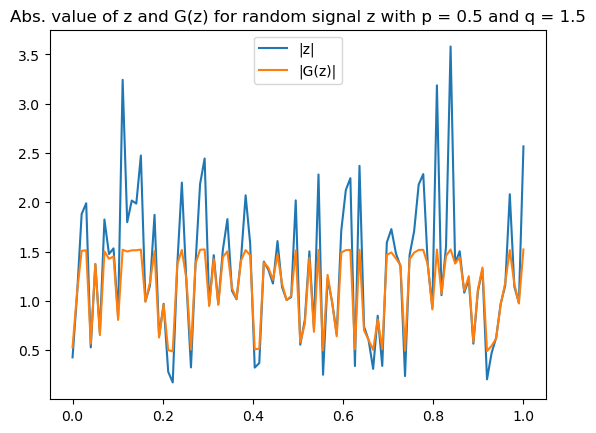

In [11]:
# for random input, this is the kind of signal the model generates
p           = 0.5
q           = 1.5
G_smooth    = lambda z : fit_sigmoid(z,p,q)

z = np.random.randn(n) + 1j*np.random.randn(n)
zc = np.concatenate((np.real(z), np.imag(z)))

# test directly
Gsmoothc = G_smooth(zc)
l = len(Gsmoothc)//2
Gsmooth = Gsmoothc[:l] + 1j*Gsmoothc[l:]
print(Gsmooth.shape)

# test operator class
Gsmoothrc = Greal.eval(zc)
Gsmoothic = Gimag.eval(zc)
Gsmooth = Gsmoothrc + 1j*Gsmoothic
print(Gsmooth.shape)

plt.figure()
plt.plot(domain, np.abs(z), label = '|z|')
plt.plot(domain, np.abs(Gsmooth), label = '|G(z)|')
plt.title(f'Abs. value of z and G(z) for random signal z with p = {p} and q = {q}')
plt.legend()
plt.show()

In [ ]:
#Xhat1, errors1, zhat1 = run_experiment(Xtrue, A, I, sigmas) 
# currently doesn't work because now expects input Gr, Gi, so not a single operator I

In [12]:
Xhat2, errors2, _ = run_experiment(Xcomplex, A, Greal, Gimag, sigmas)

200


ValueError: dimension mismatch

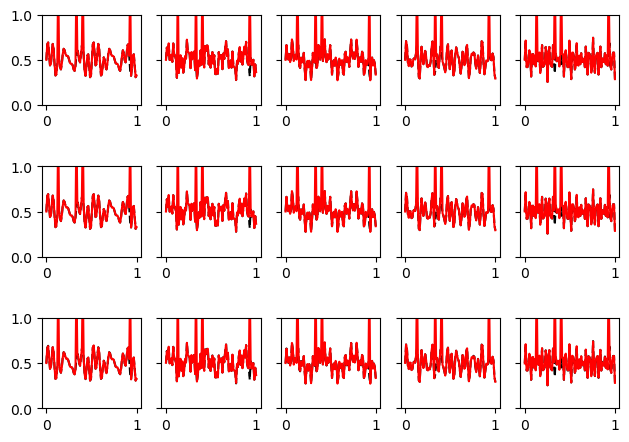

sigma    | error (std)
1.00e-03 | 3.64e-01 (1.90e-02)
1.00e-02 | 3.64e-01 (1.90e-02)
1.00e-01 | 3.64e-01 (1.90e-02)


In [43]:
plot_experiment(Xhat1, errors1, Xtrue, sigmas)

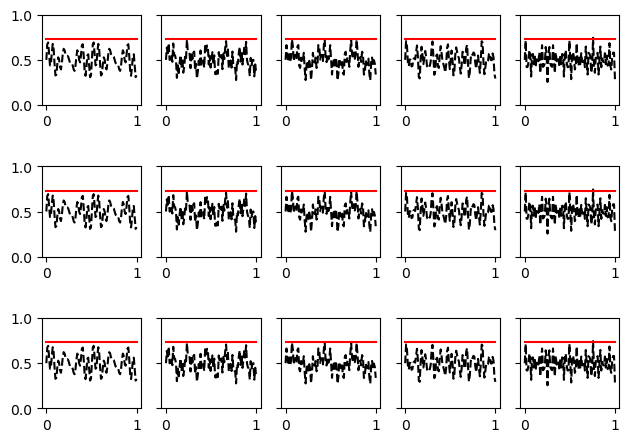

sigma    | error (std)
1.00e-03 | 4.96e-01 (1.27e-16)
1.00e-02 | 4.96e-01 (1.27e-16)
1.00e-01 | 4.96e-01 (1.27e-16)


In [58]:
plot_experiment(Xhat2, errors2, Xtrue, sigmas)

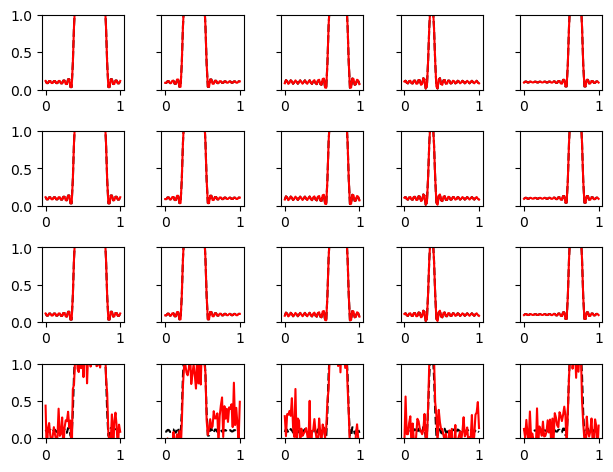

sigma    | error (std)
1.00e-03 | 6.09e-07 (1.21e-07)
1.00e-02 | 6.63e-06 (1.13e-06)
1.00e-01 | 6.16e-05 (1.10e-05)
1.00e+03 | 2.13e-01 (2.03e-02)


In [17]:
plot_experiment(np.imag(Xhat3), errors3, np.imag(X_complex), sigmas) 